# Multi-Scale LSTM

In [ ]:
import numpy as np
import warnings


class SubmodularPick(object):
    """Class for submodular pick

    Saves a representative sample of explanation objects using SP-LIME,
    as well as saving all generated explanations

    First, a collection of candidate explanations are generated
    (see explain_instance). From these candidates, num_exps_desired are
    chosen using submodular pick. (see marcotcr et al paper)."""

    def __init__(self,
                 explainer,
                 data,
                 predict_fn,
                 method='sample',
                 sample_size=1000,
                 num_exps_desired=5,
                 num_features=10,
                 model_regressor=None,
                 **kwargs):

        """
        Args:
            data: a numpy array where each row is a single input into predict_fn
            predict_fn: prediction function. For classifiers, this should be a
                    function that takes a numpy array and outputs prediction
                    probabilities. For regressors, this takes a numpy array and
                    returns the predictions. For ScikitClassifiers, this is
                    `classifier.predict_proba()`. For ScikitRegressors, this
                    is `regressor.predict()`. The prediction function needs to work
                    on multiple feature vectors (the vectors randomly perturbed
                    from the data_row).
            method: The method to use to generate candidate explanations
                    method == 'sample' will sample the data uniformly at
                    random. The sample size is given by sample_size. Otherwise
                    if method == 'full' then explanations will be generated for the
                    entire data. l
            sample_size: The number of instances to explain if method == 'sample'
            num_exps_desired: The number of explanation objects returned
            num_features: maximum number of features present in explanation


        Sets value:
            sp_explanations: A list of explanation objects that has a high coverage
            explanations: All the candidate explanations saved for potential future use.
              """

        top_labels = kwargs.get('top_labels', 1)
        if 'top_labels' in kwargs:
            del kwargs['top_labels']
        # Parse args
        if method == 'sample':
            if sample_size > len(data):
                warnings.warn("""Requested sample size larger than
                              size of input data. Using all data""")
                sample_size = len(data)
            all_indices = np.arange(len(data))
            np.random.shuffle(all_indices)
            sample_indices = all_indices[:sample_size]
        elif method == 'full':
            sample_indices = np.arange(len(data))
        else:
            raise ValueError('Method must be \'sample\' or \'full\'')

        # Generate Explanations
        self.explanations = []
        for i in sample_indices:
            self.explanations.append(
                explainer.explain_instance(
                    data[i], predict_fn, num_features=num_features,
                    top_labels=top_labels,model_regressor=model_regressor,
                    **kwargs))
        # Error handling
        try:
            num_exps_desired = int(num_exps_desired)
        except TypeError:
            return("Requested number of explanations should be an integer")
        if num_exps_desired > len(self.explanations):
            warnings.warn("""Requested number of explanations larger than
                           total number of explanations, returning all
                           explanations instead.""")
        num_exps_desired = min(num_exps_desired, len(self.explanations))

        # Find all the explanation model features used. Defines the dimension d'
        features_dict = {}
        feature_iter = 0
        for exp in self.explanations:
            labels = exp.available_labels() if exp.mode == 'classification' else [1]
            for label in labels:
                for feature, _ in exp.as_list(label=label):
                    if feature not in features_dict.keys():
                        features_dict[feature] = (feature_iter)
                        feature_iter += 1
        d_prime = len(features_dict.keys())

        # Create the n x d' dimensional 'explanation matrix', W
        W = np.zeros((len(self.explanations), d_prime))
        for i, exp in enumerate(self.explanations):
            labels = exp.available_labels() if exp.mode == 'classification' else [1]
            for label in labels:
                for feature, value in exp.as_list(label):
                    W[i, features_dict[feature]] += value

        # Create the global importance vector, I_j described in the paper
        importance = np.sum(abs(W), axis=0)**.5

        # Now run the SP-LIME greedy algorithm
        remaining_indices = set(range(len(self.explanations)))
        V = []
        for _ in range(num_exps_desired):
            best = 0
            best_ind = None
            current = 0
            for i in remaining_indices:
                current = np.dot(
                        (np.sum(abs(W)[V + [i]], axis=0) > 0), importance
                        )  # coverage function
                if current >= best:
                    best = current
                    best_ind = i
            V.append(best_ind)
            remaining_indices -= {best_ind}

        self.sp_explanations = [self.explanations[i] for i in V]
        self.V = V

## Reproducilibilidad

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
# for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

##Librerías

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import pandas as pd
import keras

import numpy as np
import sys
import os
import random

import numpy as np
import tensorflow as tf
from keras.models import load_model, Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, \
Reshape, Lambda, Conv1D, MaxPooling1D, Flatten, LocallyConnected1D, SimpleRNN, GRU, Attention
from keras import regularizers, optimizers
from keras.layers import Attention, AdditiveAttention, MultiHeadAttention

import lime


import pandas as pd
import numpy as np
np.random.seed(0)
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import linear_model
from lime import lime_tabular

#from google.colab import drive

##Preprocesamiento y validación

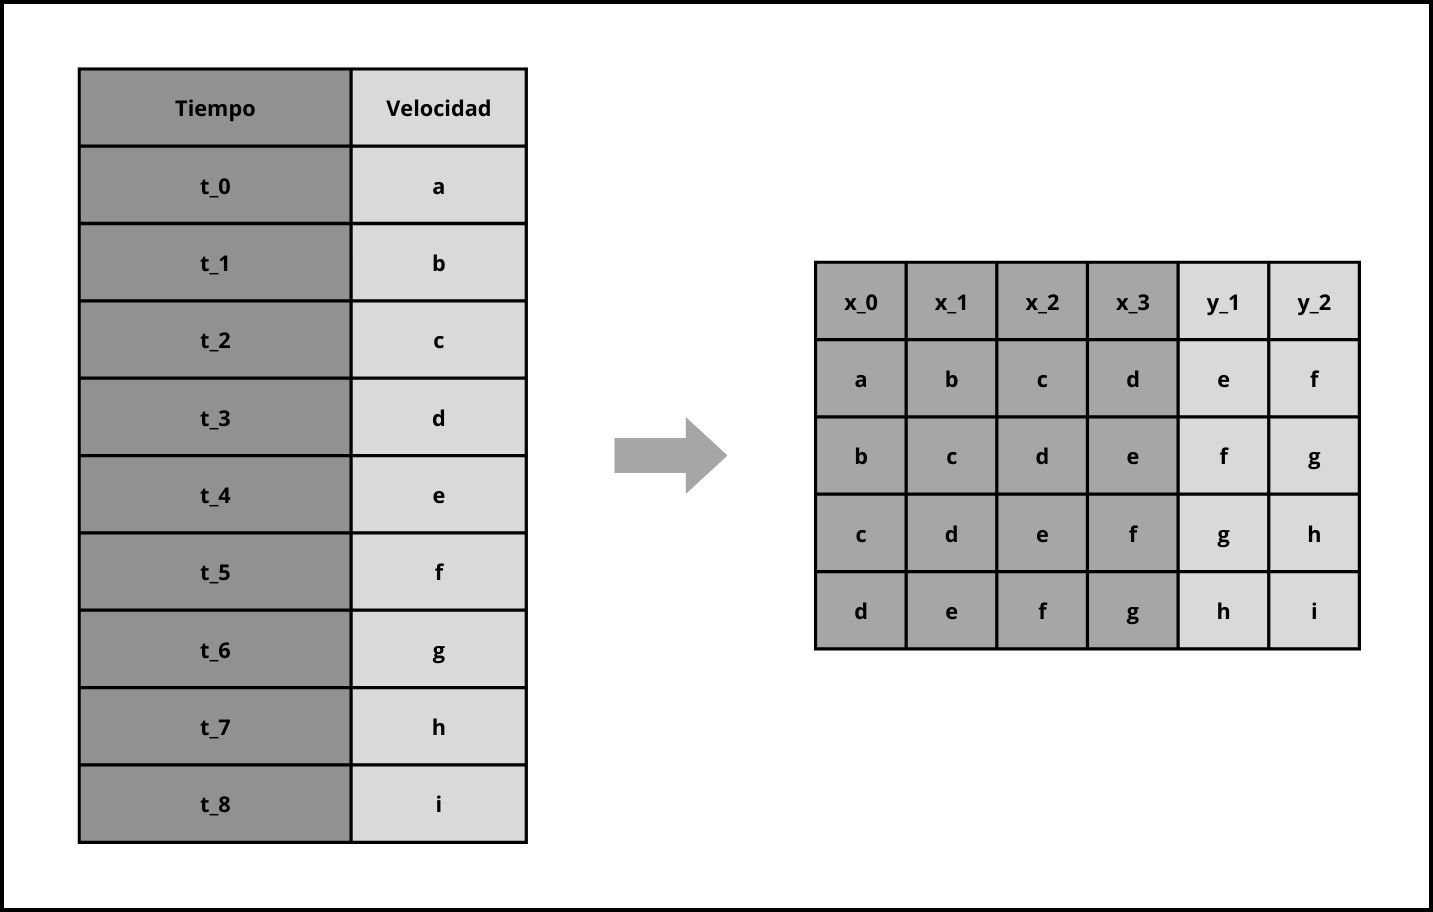

In [ ]:
def preprocessing_timeserie(window_size,target_size,aggregated_data):
  #window_size: tamaño de la ventana de input
  #target_size: tamaño de la ventana de predicción
  #aggregated_data: data agregada

  input_windows=[]
  target_windows=[]
  for i in range(int(len(aggregated_data)-window_size-target_size+1)):
      input_window = aggregated_data[i : i + window_size]
      target_window = aggregated_data[i + window_size : i + window_size + target_size]
      input_windows.append(input_window)
      target_windows.append(target_window)
  input_windows = np.array(input_windows)
  target_windows = np.array(target_windows)

  return input_windows, target_windows

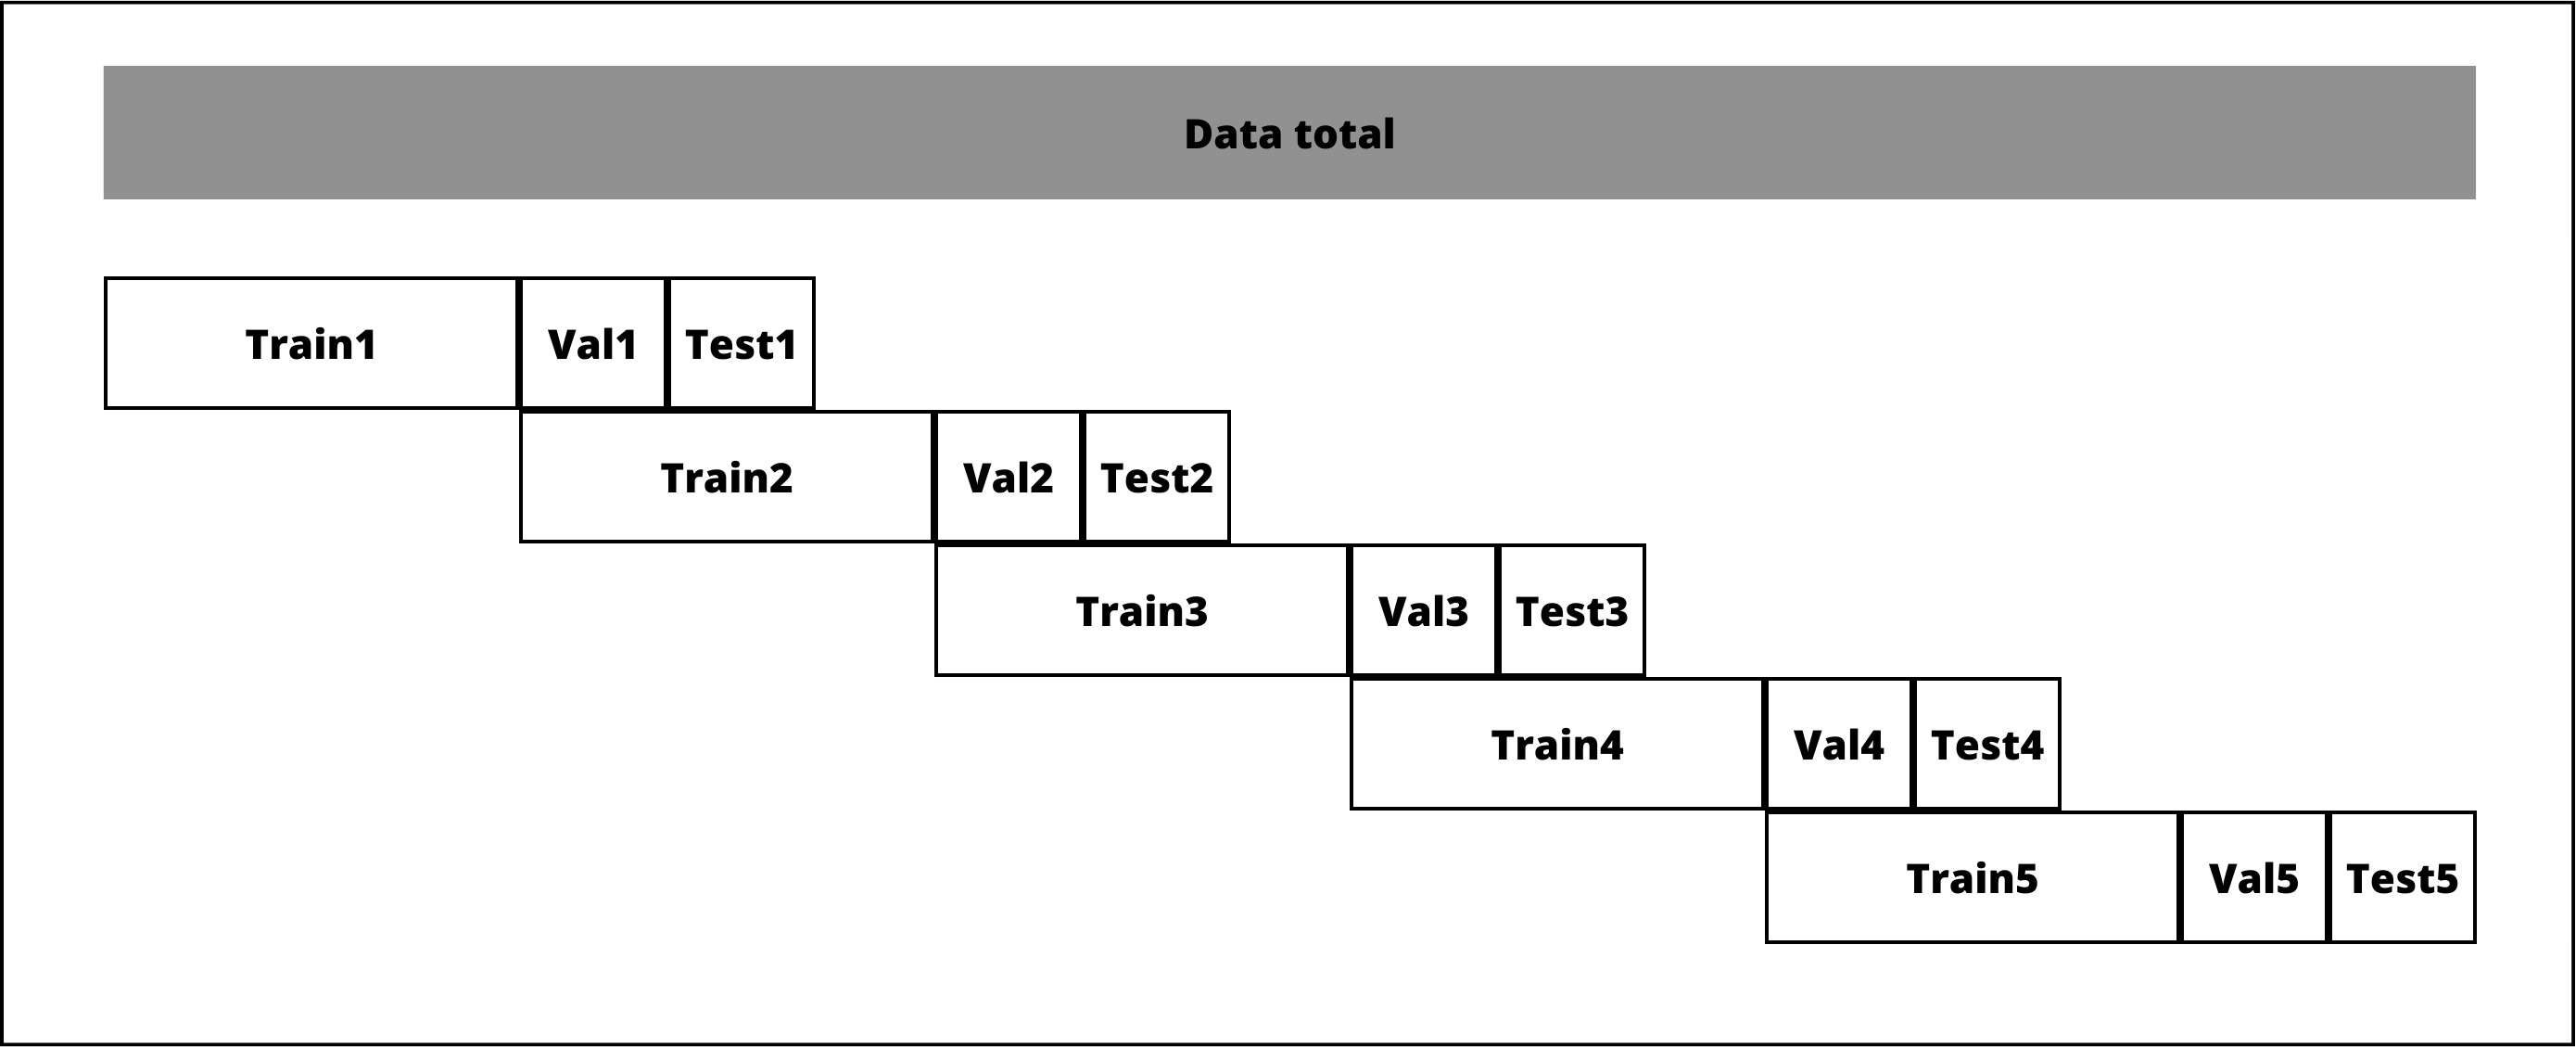

In [ ]:
def blocked_cross_val_overlap(n_blocks, model, input_windows, target_windows, test_size, validation_size, epochs,batch_size,overlap):
  #n_blocks: cantidad de bloques
  #model: modelo a evaluar
  #input_windows: Conjunto X ya procesado
  #target_windows: Conjunto y ya procesado
  #test_size: tamaño de el conjunto de testeo ej:0.1
  #validation_size: tamaño del conjunto de validación ej:0.1
  #epochs: cantidad de epochs de entrenamiento
  #batch_size: Número de ejemplos que se pasan al algoritmo en cada iteración


  y = int(len(input_windows)/(n_blocks + (n_blocks - 1) * overlap))
  x = int(y *(1 - overlap))

  rmse_v=[]
  mae_v=[]
  rmse=[]
  mae=[]

  for i in range(n_blocks):
    print("Fitting bloque", i+1)
    window_i = input_windows[(i)*x: (i+1)*y]
    target_i = target_windows[(i)*x: (i+1)*y]

    X_train = window_i[:x]
    y_train = target_i[:x]

    X_val = window_i[x : int(x + y*validation_size)]
    y_val = target_i[x : int(x + y*validation_size)]

    X_test = window_i[int(x + y*validation_size):int(x + y*(validation_size+test_size))]
    y_test = target_i[int(x + y*validation_size):]
    model_i = model
    model_i.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))#, verbose=0) #Cambiar verbose si se desea visualizar el progreso
    print(model_i.summary())
    y_pred_val = model_i.predict(X_val)
    y_pred = model_i.predict(X_test)
    rmse_k_v=[]
    mae_k_v=[]

    for k in range(len(X_val)):
      rmse_k_v.append(mean_squared_error(y_val[k], y_pred_val[k], squared=False))
      mae_k_v.append(mean_absolute_error(y_val[k], y_pred_val[k]))

    rmse_v.append(np.mean(rmse_k_v))
    mae_v.append(np.mean(mae_k_v))

    rmse_k=[]
    mae_k=[]

    for k in range(len(X_test)):
      rmse_k.append(mean_squared_error(y_test[k], y_pred[k], squared=False))
      mae_k.append(mean_absolute_error(y_test[k], y_pred[k]))
    rmse.append(np.mean(rmse_k))
    mae.append(np.mean(mae_k))
#Retorna metricas de validación y testeo
  return np.mean(rmse), np.mean(mae), np.mean(rmse_v), np.mean(mae_v)

In [ ]:
cd "datasets"

#LSTM_Ms


The MSE loss function was employed and the Adam optimizer with
learning rates of 0.01 or 0.001 led to good convergence in all the
models. l2 regularization was fixed to 0.001.

In [ ]:
tf.random.set_seed(0)

In [ ]:
# Esto se usa para crear una capa customizada que selecciona los últimos valores de cada escala. Por ejemplo,
# si la serie de tiempo tiene 120 valores, y creamos una escala de tamaño 10, eso generará una serie de tiempo de tamaño 12.
# Luego, si queremos procesar los últimos 5 valores de esa escala, esta función selecciona esos 5 valores y se los entrega
# a la capa LSTM que la procesa.
def z_n(x, position):
    return x[:, -position:, :]

def LSTM_Ms(lags, time_steps, processed_scales, dense_nodes, lstm_nodes, l2, final_nodes, rnn,lr):

    # lags: tamaño de cada una de las escalas que se van a construir
    # Ejemplo:  si queremos generar 2 escalas, una de tamaño 1 y una de tamaño 24, lags=[1, 24]
    # time_steps: cantidad de valores a procesar por RNNs de cada una de las escalas generadas [0, 2, 2]
    # Ejemplo: si queremos generar 2 escalas, una de tamaño 1 y una de tamaño 24, time_steps=[1,2] tomará
    # 1 elemento de la escala de tamaño 1 y 2 elementos de la escala de tamaño 2.  (12,10) y (12,15)
    # processed_scales: me dice que escalas quiero procesar.
    # Ejemplo: si queremos procesar las escalas de lag 1 y 24, processed_scales=[0,1]. Si sólo quisieramos procesar
    # la escala de lag 24, usamos processed_scales=[1].
    # dense_nodes: cantidad de nodos que utilizan las capas densas para generar las escalas [10, 30]
    # lstm_nodes: cantidad de bloques de memoria que debe tener cada lstm [10, 20, 25]
    # final_nodes: cantidad de nodos que utiliza la capa densa final para procesar los valores concatenados de cada RNN
    # (puede ser 0)

    if rnn == "lstm":
        RNN = LSTM
    elif rnn == "gru":
        RNN = GRU


    number_layers = len(lags)

    # Tamaño de la serie de tiempo que se debe entregar al modelo. Se calcula obteniendo el máximo de
    # multiplcar el tamaño de cada escala (lag[i])  por la cantidad de valores que se procesan en su escala (timestep[i]).
    # por ejemplo si tenemos 2 escalas, tamaños 1 y 12, y queremos procesar 10 valores de la escala 1 y 5 valores de la
    # escala 12, tenemos que entregar al modelo series de tiempo de tamaño 12*5=60 para lograrlo. Por ende, la entrada
    # del modelo para entrenarlo van a ser datos de tamaño (N, 60, 1), donde N es la cantidad de datos que tenemos.

    max_input_values = np.max([lags[i]*time_steps[i] for i in range(number_layers)])
    print(max_input_values)
    inputs = Input(shape = (168, 1))

    dense_layers = []

    dense_layers.append(inputs)

    # Generacion de la estructura de capas densas. Cada escala es procesada por capas densas, y el output de esas capas densas
    # constituyen la siguiente escala, que son procesadas por una siguiente estructura de capas densas. (Conv1 con
    # kernel_size=N y strides=N hace que las capas densas procesen la serie de tiempo cada N valores sin overlapping )

    for i in range(1, number_layers):

        strides =  lags[i]//lags[i-1] #floor division
        conv = Conv1D(filters = dense_nodes[i], kernel_size = strides, strides = strides, \
               activation = 'relu', use_bias = True)(dense_layers[i-1])

        print(conv)
        dense_layers.append(conv)

    lstm_layers = []

    # Toma las escalas generadas anteriormente y les incorpora las LSTM o GRU a cada una.
    for scale in processed_scales:

        # Acá se seleccionan los últimos time_steps[scale] elementos que se quieren procesar de cada escala, recibe
        # la capa densa de la escala y luego se le pasa a la RNN seleccionada.
        lambda_layer = Lambda(z_n, arguments = {'position': time_steps[scale]})(dense_layers[scale])
        #lambda_layer = dense_layers[scale]
        lstm = RNN(lstm_nodes[scale], activation='tanh', recurrent_activation='sigmoid',\
                activity_regularizer=regularizers.l2(l2), \
                recurrent_regularizer=regularizers.l2(l2))(lambda_layer)

        lstm_layers.append(lstm)

    # Concatenamos el output de las RNN utilizadas. Si sólo estamos procesando una escala, simplemente tomamos el output,
    # de esa RNN.

    if len(lstm_layers) > 1:

        concatenated = keras.layers.concatenate(lstm_layers)

    else:

        concatenated = lstm_layers[0]

    # Al resultado de la concatenación le aplicamos un último procesamiento a partir de una capa densa que genera nuestro output
    # final.
    if final_nodes != 0:

        concatenated = Dense(final_nodes, activation = 'relu')(concatenated)

    outputs = Dense(24)(concatenated) #Cambio de 1 a 24 para predicción

    model = Model(inputs = inputs, outputs = outputs)
    ad = optimizers.Adam(learning_rate=lr)

    model.compile(loss = 'mse', optimizer = ad)

    return model

# Preprocesamiento b08

In [ ]:
wind_b08_df = pd.read_csv("wind_e01_no_na.csv" )#, index_col=0)
wind_b08_df['GMT'] = pd.to_datetime(wind_b08_df.GMT)
wind_b08_df

In [ ]:
wind_b08_df.set_index('GMT', inplace=True) #320595
wind_b08_df=wind_b08_df.iloc[:,:1]
print(wind_b08_df.isnull().values.any())
# Resample la data por hora y agregarla usando la media
aggregated_data = wind_b08_df.resample('H').mean()
#Interpolamos los nan https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
aggregated_data['Velocidad_de_viento_en_20.0_metros_[mean,m/s]'] = aggregated_data['Velocidad_de_viento_en_20.0_metros_[mean,m/s]'].interpolate()
aggregated_data

In [ ]:
aggregated_data.loc[aggregated_data['Velocidad_de_viento_en_20.0_metros_[mean,m/s]'].isnull()]

In [ ]:
input_windows, target_windows = preprocessing_timeserie(24*7,24,aggregated_data)

In [ ]:
model_1=LSTM_Ms(lags=[1, 24], time_steps=[12, 15], processed_scales=[0,1], dense_nodes=[10, 30], lstm_nodes=[10, 20], l2=0.001, final_nodes=0, rnn='lstm', lr=0.01)#0.001
#model_2=LSTM_Ms_1(lags=[1, 24], time_steps=[12, 15], processed_scales=[0,1], dense_nodes=[10, 30], lstm_nodes=[20, 20], l2=0.01, final_nodes=0, rnn='lstm', lr=0.001)


In [ ]:
rmse_1,mae_1,rmse_1v,mae_1v=blocked_cross_val_overlap(5, model_1, input_windows, target_windows, 0.05, 0.05, 10 ,32,0.3)
#rmse_2,mae_2,rmse_2v,mae_2v=blocked_cross_val_overlap(5, model_2, input_windows, target_windows, 0.05, 0.05, 10 ,32,0.3)


In [ ]:
print(rmse_1,mae_1,rmse_1v,rmse_1v)

In [ ]:
input_windows.shape

In [ ]:
df_x=pd.DataFrame(data=np.reshape(input_windows, (25528, 168)))
df_y=pd.DataFrame(data=np.reshape(target_windows,(25528, 24) ))

df_x['target_1'] = df_y.iloc[:,0]
df_x['target_2'] = df_y.iloc[:,1]
df_x['target_3'] = df_y.iloc[:,2]
df_x['target_4'] = df_y.iloc[:,3]
df_x['target_5'] = df_y.iloc[:,4]
df_x['target_6'] = df_y.iloc[:,5]
df_x['target_7'] = df_y.iloc[:,6]
df_x['target_8'] = df_y.iloc[:,7]
df_x['target_9'] = df_y.iloc[:,8]
df_x['target_10'] = df_y.iloc[:,9]
df_x['target_11'] = df_y.iloc[:,10]
df_x['target_12'] = df_y.iloc[:,11]
df_x['target_13'] = df_y.iloc[:,12]
df_x['target_14'] = df_y.iloc[:,13]
df_x['target_15'] = df_y.iloc[:,14]
df_x['target_16'] = df_y.iloc[:,15]
df_x['target_17'] = df_y.iloc[:,16]
df_x['target_18'] = df_y.iloc[:,17]
df_x['target_19'] = df_y.iloc[:,18]
df_x['target_20'] = df_y.iloc[:,19]
df_x['target_21'] = df_y.iloc[:,20]
df_x['target_22'] = df_y.iloc[:,21]
df_x['target_23'] = df_y.iloc[:,22]
df_x['target_24'] = df_y.iloc[:,23]
df_x.columns = df_x.columns.astype(str)
df_x.columns

In [ ]:
model_1=LSTM_Ms(lags=[1, 24], time_steps=[12, 10], processed_scales=[0,1], dense_nodes=[10, 30], lstm_nodes=[10, 20], l2=0.001, final_nodes=0, rnn='lstm', lr=0.01)#0.001

X_train, X, y_train, y = train_test_split(df_x.iloc[:,:-24], df_x.iloc[:,-24:], test_size=0.1, shuffle=False, stratify = None)

X_test, X_val, y_test, y_val = train_test_split(X, y, test_size=0.5, shuffle=False, stratify = None)


In [ ]:
train = X_train.iloc[:]
train[['target_1','target_2','target_3','target_4','target_5','target_6','target_7','target_8','target_9','target_10','target_11','target_12','target_13','target_14','target_15','target_16','target_17','target_18','target_19','target_20','target_21','target_22','target_23','target_24']] = y_train.iloc[:]
train

In [ ]:
history=model_1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))#, verbose=0) #Cambiar verbose si se desea visualizar el progreso
y_pred = model_1.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_pred, squared=False), mean_absolute_error(y_test, y_pred)

## LIME

In [ ]:
targets = ['target_1','target_2','target_3','target_4','target_5','target_6','target_7','target_8','target_9','target_10','target_11','target_12','target_13','target_14','target_15','target_16','target_17','target_18','target_19','target_20','target_21','target_22','target_23','target_24']
explainers=[]
for i in range(24):
    explainer_i = lime_tabular.LimeTabularExplainer(np.array(X_train),
                    feature_names=train.columns.values.tolist()[:168],
                    class_names=[targets[i]],
                    verbose=True, mode='regression')
    explainers.append(explainer_i)

In [ ]:
reg1 = linear_model.ElasticNet(alpha=0.3)
reg2 = linear_model.Lasso(alpha=0.3)# BEST
reg3 = linear_model.Ridge(alpha=0.3)
#reg2 con alpha 0.3
instancias=random.sample(range(0, len(X_test)), 10)

In [ ]:
def predict_function_0(inputs):
    predictions=np.delete(model_1.predict(inputs),[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_1(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_2(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_3(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_4(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_5(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_6(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_7(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_8(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_9(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_10(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_11(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_12(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_13(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_14(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_15(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_16(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_17(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_18(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23],axis=1) 
    return predictions

def predict_function_19(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23],axis=1) 
    return predictions

def predict_function_20(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21,22,23],axis=1) 
    return predictions

def predict_function_21(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23],axis=1) 
    return predictions

def predict_function_22(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23],axis=1) 
    return predictions

def predict_function_23(inputs):
    predictions=np.delete(model_1.predict(inputs),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],axis=1) 
    return predictions

In [ ]:
predict_function=[predict_function_0,predict_function_1,predict_function_2,predict_function_3,predict_function_4,predict_function_5,predict_function_6,predict_function_7,predict_function_8,predict_function_9,predict_function_10,predict_function_11,predict_function_12,predict_function_13,predict_function_14,predict_function_15,predict_function_16,predict_function_17,predict_function_18,predict_function_19,predict_function_20,predict_function_21,predict_function_22,predict_function_23]
exp1=[]
for k,j in zip(explainers,predict_function):
    exp_0 = [0]*10
    for i in range(1):
        id_instancia = instancias[i]
        input_instance = X_test.values[id_instancia] 
        exp_0[i] = k.explain_instance(input_instance, j , num_features=10, model_regressor=reg1)
    exp1.append(exp_0)

In [ ]:
for k in range(24):
    exp_i = exp1[k]
    for i in range(4):
        print('Tiempo ',k)
        print('Instancia ',i)
        id_instancia = instancias[i]
        exp_i[i].show_in_notebook(show_table=True, show_all=False)
        print(X_test.iloc[id_instancia])
    

In [ ]:
exp2=[]
for k,j in zip(explainers,predict_function):
    exp_0 = [0]*10
    for i in range(10):
        id_instancia = instancias[i]
        input_instance = X_test.values[id_instancia] 
        exp_0[i] = k.explain_instance(input_instance, predict_function_0 , num_features=10, model_regressor=reg2)
    exp2.append(exp_0)


In [ ]:
for k in range(24):
    exp_i = exp2[k]
    for i in range(4):
        print('Tiempo ',k)
        print('Instancia ',i)
        id_instancia = instancias[i]
        exp_i[i].show_in_notebook(show_table=True, show_all=False)
        print(X_test.iloc[id_instancia])
    
    

In [ ]:
exp3=[]
for k,j in zip(explainers,predict_function):
    exp_0 = [0]*10
    for i in range(10):
        id_instancia = instancias[i]
        input_instance = X_test.values[id_instancia] 
        exp_0[i] = k.explain_instance(input_instance, predict_function_0 , num_features=10, model_regressor=reg3)
    exp3.append(exp_0)

In [ ]:
for k in range(24):
    exp_i = exp3[k]
    for i in range(4):
        print('Tiempo ',k)
        print('Instancia ',i)
        id_instancia = instancias[i]
        exp_i[i].show_in_notebook(show_table=True, show_all=False)
        print(X_test.iloc[id_instancia])
    

##SP_LIME

In [ ]:
predict_function=[predict_function_0,predict_function_1,predict_function_2,predict_function_3,predict_function_4,predict_function_5,predict_function_6,predict_function_7,predict_function_8,predict_function_9,predict_function_10,predict_function_11,predict_function_12,predict_function_13,predict_function_14,predict_function_15,predict_function_16,predict_function_17,predict_function_18,predict_function_19,predict_function_20,predict_function_21,predict_function_22,predict_function_23]
exp1=[]
for k,j in zip(explainers,predict_function):
    exp_0 = SubmodularPick (k,X_test.values, j ,model_regressor=reg2,num_exps_desired=1,sample_size=50)
    exp1.append(exp_0)

In [ ]:
for i in range(24): 
    sp_obj = exp1[i]
    [exp.show_in_notebook() for exp in sp_obj.sp_explanations]